# Imports

In [1]:
### IMPORTS ###

import numpy as np
import os
from pprint import pprint
from backports import lzma
from string import punctuation
import timeit
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load and Plot

In [2]:
### LOAD TOKEN WORD VECS ###

def load_vecs(filename="latin.vectors"):
    file = open(filename, "rb")
    vecs = {}
    print("Loading word vectors from {}...".format(filename))
    for l in file:
        l_split = l.split()
        token = l_split[0]
        if token[-1].isalpha() and token[0].isalpha():
            vec = np.array([float(dim) for dim in l_split[1:]])
            vecs[token] = vec
    print("Loaded {} vectors!".format(len(vecs)))
    return vecs
        
token_vectors = load_vecs()
    

Loading word vectors from latin.vectors...
Loaded 492675 vectors!


In [3]:
### LOAD LEMMA VECTORS ###
lemma_vectors = load_vecs("latin_lemma.vectors")

Loading word vectors from latin_lemma.vectors...
Loaded 73163 vectors!


In [4]:
### LOAD LEMMA TO TOKEN MAP (REDUCED)

print("Loading map...")
map = pickle.load(open("latin_token_lemma_mapping/lemma_token_map.pkl"))
print("Loading reduced map...")
reduced_map = pickle.load(open("latin_token_lemma_mapping/reduced_lemma_token_map.pkl"))
print("Done!")

Loading map...
Loading reduced map...
Done!


In [22]:
lemma = "leg"
print(reduced_map["dic"])
# print(token_vectors["puero"])

['dicendum', 'diceremus', 'dicasse', 'dich', 'dici', 'dick', 'dico', 'dict', 'dixerimus', 'dicata', 'dicato', 'dicati', 'dixerint', 'dicuntur', 'dicatos', 'dicenti', 'dicandam', 'dicente', 'dicendo', 'dicendi', 'dicenda', 'diceres', 'dicentis', 'dicarent', 'dixit', 'dicentia', 'dicentes', 'diceret', 'dixisset', 'dicentium', 'dicebatur', 'dicare', 'dicari', 'dictos', 'dicendos', 'dicet', 'dices', 'dicatis', 'dicatarum', 'dicere', 'dicatas', 'dicetur', 'dicemus', 'dicatae', 'dicta', 'dicto', 'dicti', 'diximus', 'dicaverunt', 'dixisse', 'dicunt', 'dicatum', 'dicantur', 'dicavit', 'dicatus', 'dicatur', 'dicatorum', 'dicendas', 'dixi', 'dicerent', 'dicebat', 'dicendis', 'dicendam', 'dictis', 'dicaret', 'dicitis', 'dictas', 'dictorum', 'dictae', 'dictam', 'dictum', 'dicentem', 'dicimur', 'dicimus', 'dicerentur', 'dictus', 'dictur', 'dicentur', 'dicentibus', 'dicebant', 'dictarum', 'dixerunt', 'dicamus', 'dicito', 'dicis', 'dicit', 'dicendorum', 'dicite', 'dicavi', 'dicaverit', 'dicam', 'dixe

['puell', 'puellis', 'puellam', 'puellarum', 'puella', 'puellae', 'puellas', 'puellari']


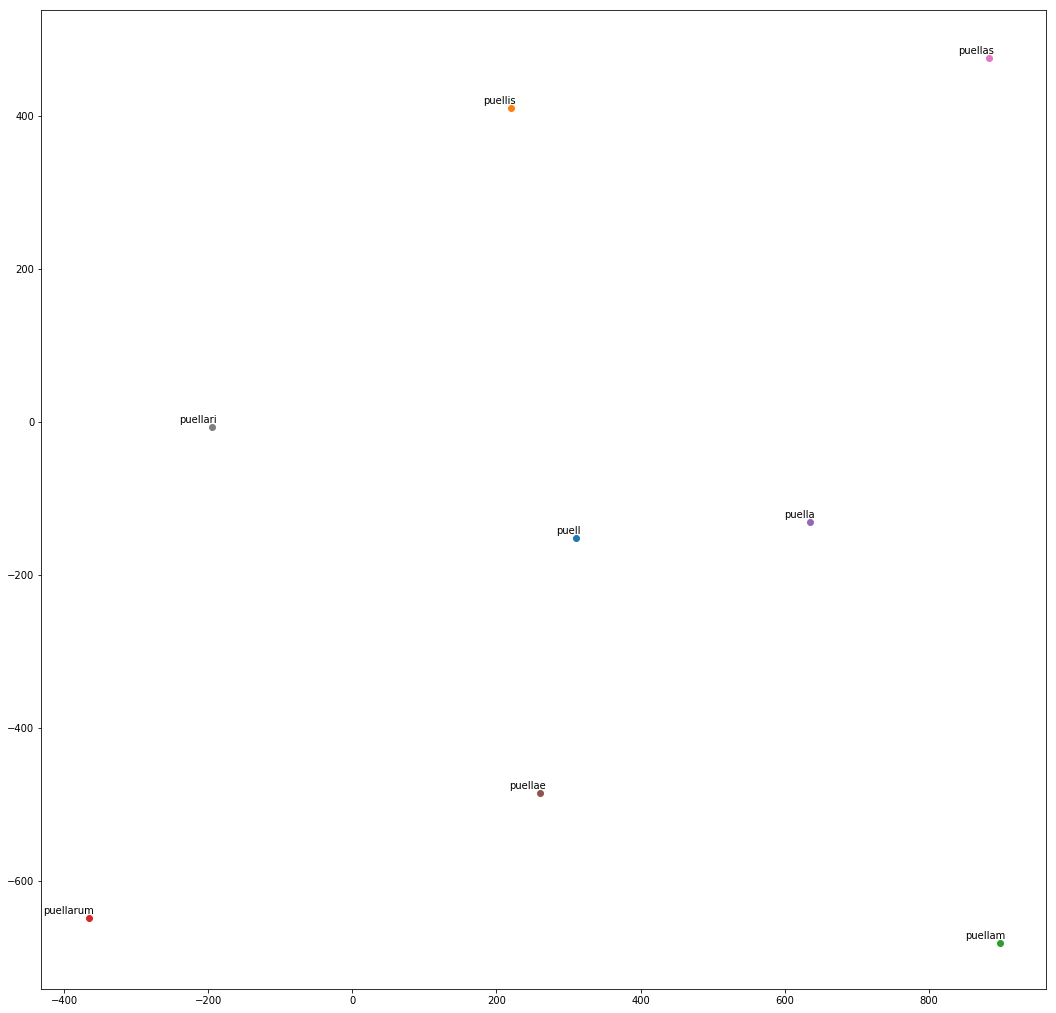

In [24]:
### PICK LEMMA AND PLOT TOKENS ###

lemma = "puell"
tokens = reduced_map[lemma]
l_vec = lemma_vectors[lemma]
t_vecs = [token_vectors.get(t) for t in tokens]
X = [l_vec] + t_vecs
Y = [lemma] + tokens
print(Y)

def reduce_dims(input):
    tsne = TSNE(perplexity=2,
                n_components=2,
                init='pca',
                n_iter=5000,
                method='exact')
    low_dim_embs = tsne.fit_transform(input)
    return low_dim_embs

def save_plot(embeds, labels, savename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
      x, y = low_dim_embs[i, :]
      plt.scatter(x, y)
      plt.annotate(
          label,
          xy=(x, y),
          xytext=(5, 2),
          textcoords='offset points',
          ha='right',
          va='bottom')
    plt.savefig(savename)

low_dim_embs = reduce_dims(X)
save_plot(low_dim_embs, Y, "plots/" + lemma)


# Data Creation

In [ ]:
### EXTRACT TOKEN LEMMA MAPPINGS ###

def token_lemma_map_xz(dir="../Latin-annotated-conll17/Latin/", save_dir="latin_token_lemma_mapping/"):
    files = os.listdir(dir)
    xz_files = sorted([f for f in files if f[-3:] == ".xz"], reverse=True)
    already_done = os.listdir(save_dir)
    for xz_file in xz_files:
        if ".".join(xz_file.split(".")[:-1]) + ".tsv" in already_done:
            continue
        xz_dir = dir + xz_file
        text_io = lzma.open(xz_dir)
        extract(text_io, xz_file, save_dir)

def token_lemma_map_ittb(dir="../UD_Latin-ITTB/", save_dir="latin_token_lemma_mapping/"):
    files = os.listdir(dir)
    conllu_files = sorted([f for f in files if f[-7:] == ".conllu"])
    already_done = os.listdir(save_dir)
    for conllu_file in conllu_files:
        if ".".join(conllu_file.split(".")[:-1]) + ".tsv" in already_done:
            continue
        conllu_dir = dir + conllu_file
        text_io = open(conllu_dir)
        extract(text_io, conllu_file, save_dir)
        
def extract(file_io, filename, save_dir):
    mappings = set()
    start = timeit.default_timer()
    print("Processing file: {}".format(filename))
    for i, raw_l in enumerate(file_io):
        print_every = 100000
        if i % print_every == 0:
            print("\t{} - Tokens: {} Mappings: {}".format(filename, i, len(mappings)))
        l = raw_l.split("\t")
        try:
            token, lemma = l[1:3]
        except ValueError:
            continue
        mappings.add(token + "\t" + lemma)
    end = timeit.default_timer()
    print("File {} processed in {}s".format(filename, end-start))
    save_filename = ".".join(filename.split(".")[:-1]) + ".tsv"
    with open(save_dir + save_filename, "wb") as output:
        for m in mappings:
            output.write(m + "\n")
    print("Saved in {}{}".format(save_dir, save_filename))
    print

token_lemma_map_ittb()
token_lemma_map_xz()


In [ ]:
### CREATE DICT THAT MAPS LEMMAS TO TOKENS ###

def generate_mappings(dir="latin_token_lemma_mapping/"):
    files = os.listdir(dir)
    mappings = {}
    for file in files:
        if file[-4:] != ".tsv":
            continue
        print("Processing {}".format(file))
        for l in open(dir+file):
            try:
                token, lemma = l[:-2].split("\t")
            except ValueError:
                continue
            if valid(lemma) and valid(token):
                if lemma not in mappings:
                    mappings[lemma] = set([token])
                else:
                    mappings[lemma].add(token)
        print("Num mappings: {}".format(len(mappings)))
        print
    return mappings

def valid(word):
    if not word:
        return False
    for ch in word:
        if ch.isdigit():
            return False
        if ch in ["\\", "/", ",", "?", "!"]:
            return False
    return True

lemma_token_map = generate_mappings()
print("Pickling...")
pickle.dump(lemma_token_map, open("latin_token_lemma_mapping/lemma_token_map.pkl","wb"))
print("Done")

In [ ]:
### CREATES A LEMMA TOKEN MAP THAT ONLY CONTAINS TOKENS WITH WORD VECTORS ###

def reduce_map(token_vectors, lemma_token_map):
    ret = {}
    for lemma in lemma_token_map:
        tokens = lemma_token_map[lemma]
        ret[lemma] = []
        for token in tokens:
            if token in token_vectors:
                ret[lemma].append(token)
        if len(ret[lemma]) == 0:
            del ret[lemma]
    return ret

start = timeit.default_timer()
lemma_token_map = pickle.load(open("latin_token_lemma_mapping/lemma_token_map.pkl"))
reduced_map = reduce_map(token_vectors, lemma_token_map)
pickle.dump(reduced_map, open("latin_token_lemma_mapping/reduced_lemma_token_map.pkl", "wb"))
end = timeit.default_timer()
print(end-start)

In [ ]:
### TURN TOKEN LEVEL VECTORS TO LEMMA LEVEL VECTORS ###

# Maybe add a check that as many word vecs pass through this as tokens #



def lemmatize_vectors(token_vectors, lemma_token_map, print_every=1000):
    print("Creating vectors for {} lemmas...".format(len(reduced_map)))
    with open("latin_lemma.vectors", "wb") as output:
        output.write(str(len(lemma_token_map)) + " ")
        output.write(str(len(token_vectors["puer"])) + "\n")
        for i, lemma in enumerate(lemma_token_map):
            if i%print_every == 0:
                print("Vectors created: {}".format(i))
            tokens = lemma_token_map[lemma]
            vecs = []
            for t in tokens:
                vecs.append(token_vectors[t])
            vector = sum(vecs)/len(vecs)
            output.write(lemma + " ")
            str_vector = [str(d) for d in vector]
            output.write(" ".join(str_vector) + "\n")
    


lemmatize_vectors(token_vectors, reduced_map)
